In [1]:
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Directories where your input images are located (train, test, and validation)
train_dir = r"F:\Thesis\0.WorkHere\Train"
test_dir = r"F:\Thesis\0.WorkHere\Test"
validation_dir = r"F:\Thesis\0.WorkHere\Validation"


In [2]:

# Directory to save models and history
save_dir = r"F:\Thesis\0.WorkHere\SavedModels"

# Set hyperparameters
batch_size = 5
num_classes = 169
epochs = 20


In [3]:

# Create data generators for image preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for testing

# Create data generators for training, testing, and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to match VGG16 input size
    batch_size=batch_size,
    class_mode='categorical'  # Use categorical for multi-class classification
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)



Found 5530 images belonging to 169 classes.
Found 568 images belonging to 169 classes.
Found 986 images belonging to 169 classes.


In [4]:
# Load the pre-trained VGG16 model
base_modelVGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers except the last 3 layers
for layer in base_modelVGG16.layers[:-3]:
    layer.trainable = False

# Create a custom top classifier for the number of classes
modelvgg16 = models.Sequential()
modelvgg16.add(base_modelVGG16)
modelvgg16.add(layers.Flatten())
modelvgg16.add(layers.Dense(1024, activation='relu'))
modelvgg16.add(layers.Dropout(0.2))
modelvgg16.add(layers.Dense(num_classes, activation='softmax'))

modelvgg16.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 169)               173225    
                                                                 
Total params: 40,579,049
Trainable params: 30,583,977
Non-trainable params: 9,995,072
_________________________________________________________________


In [5]:
modelvgg16.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [6]:
# Define the checkpoint callback to save the model
checkpoint = ModelCheckpoint(
    filepath=save_dir + '/vgg16_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)



In [7]:
# Train the model and save the history
history_vgg16 = modelvgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint]
)



Epoch 1/20
1106/1106 [==============================] - ETA: 0s - loss: 4.2239 - accuracy: 0.1098
Epoch 1: val_loss improved from inf to 2.44010, saving model to F:\Thesis\0.WorkHere\SavedModels\vgg16_model.h5
1106/1106 [==============================] - 115s 100ms/step - loss: 4.2239 - accuracy: 0.1098 - val_loss: 2.4401 - val_accuracy: 0.3594
Epoch 2/20
1106/1106 [==============================] - ETA: 0s - loss: 2.0314 - accuracy: 0.4593
Epoch 2: val_loss improved from 2.44010 to 1.14805, saving model to F:\Thesis\0.WorkHere\SavedModels\vgg16_model.h5
1106/1106 [==============================] - 45s 40ms/step - loss: 2.0314 - accuracy: 0.4593 - val_loss: 1.1480 - val_accuracy: 0.6711
Epoch 3/20
1106/1106 [==============================] - ETA: 0s - loss: 1.1167 - accuracy: 0.6835
Epoch 3: val_loss improved from 1.14805 to 0.63632, saving model to F:\Thesis\0.WorkHere\SavedModels\vgg16_model.h5
1106/1106 [==============================] - 46s 41ms/step - loss: 1.1167 - accuracy: 0.68

In [8]:
# Save training history to a JSON file
with open(save_dir + '/vgg16_history.json', 'w') as f:
    json.dump(history_vgg16.history, f)






In [9]:
# Load the model and history for evaluation without retraining
from tensorflow.keras.models import load_model

model_vgg16_loaded = load_model(save_dir + '/vgg16_model.h5')




In [10]:
# Load the history
with open(save_dir + '/vgg16_history.json', 'r') as f:
    history_vgg16_loaded = json.load(f)


In [11]:
# Evaluate the model on the test data
test_loss, test_acc = model_vgg16_loaded.evaluate(test_generator)
print(f'Test accuracy vgg16: {test_acc * 100:.2f}%')

# Evaluate the model on the validation data
validation_loss, validation_acc = model_vgg16_loaded.evaluate(validation_generator)
print(f'Validation accuracy vgg16: {validation_acc * 100:.2f}%')


114/114 [==============================] - 3s 24ms/step - loss: 0.0686 - accuracy: 0.9771
Test accuracy vgg16: 97.71%
198/198 [==============================] - 4s 21ms/step - loss: 0.0769 - accuracy: 0.9746
Validation accuracy vgg16: 97.46%


In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
predictions = model_vgg16_loaded.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test set generator
true_labels = test_generator.classes

# Get class labels (optional, but useful for the classification report)
class_labels = list(test_generator.class_indices.keys())

# Ensure the classification report and confusion matrix consider all classes
labels = list(test_generator.class_indices.values())

# Print classification report
print(classification_report(true_labels, predicted_labels, labels=labels, target_names=class_labels, zero_division=1))

# Print confusion matrix
print(confusion_matrix(true_labels, predicted_labels, labels=labels))


114/114 [==============================] - 2s 17ms/step
              precision    recall  f1-score   support

       cow_1       0.00      0.00      0.00         2
      cow_10       0.00      0.00      0.00         4
     cow_101       0.00      0.00      0.00         2
     cow_110       0.00      0.00      0.00         2
     cow_112       0.00      0.00      0.00         4
     cow_113       0.00      0.00      0.00         4
     cow_118       0.00      0.00      0.00         2
     cow_119       0.00      0.00      0.00         4
     cow_120       0.00      0.00      0.00         4
     cow_121       0.00      0.00      0.00         4
     cow_122       0.00      0.00      0.00         4
     cow_123       0.00      0.00      0.00         6
     cow_124       0.00      0.00      0.00         4
     cow_126       0.00      0.00      0.00         4
     cow_127       0.00      0.00      0.00         6
     cow_129       0.00      0.00      0.00         2
      cow_13       0.00  

In [13]:
# Generate predictions
predictions = model_vgg16_loaded.predict(test_generator)

114/114 [==============================] - 2s 17ms/step


114/114 [==============================] - 2s 17ms/step


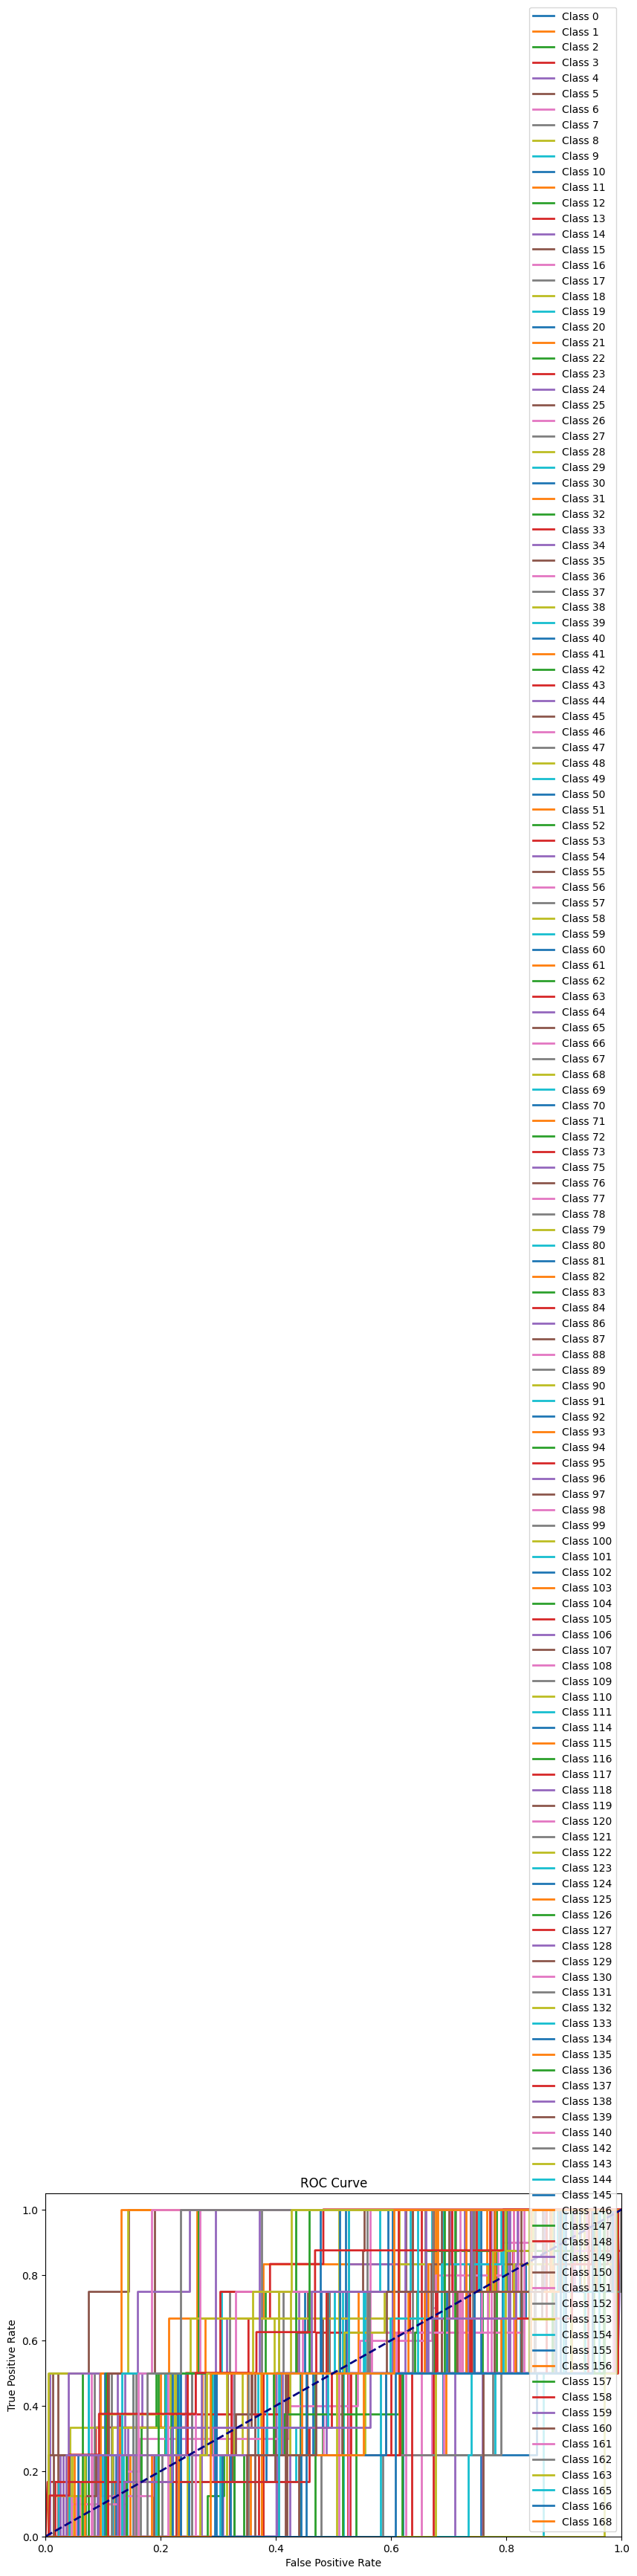

In [14]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Assuming you have test labels and predicted probabilities
y_true = test_generator.classes
y_pred = model_vgg16_loaded.predict(test_generator)

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    if sum(y_true == i) > 0:  # Check if there are positive samples for class i
        fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred[:, i])
        plt.plot(fpr, tpr, lw=2, label=f'Class {i}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


114/114 [==============================] - 2s 17ms/step


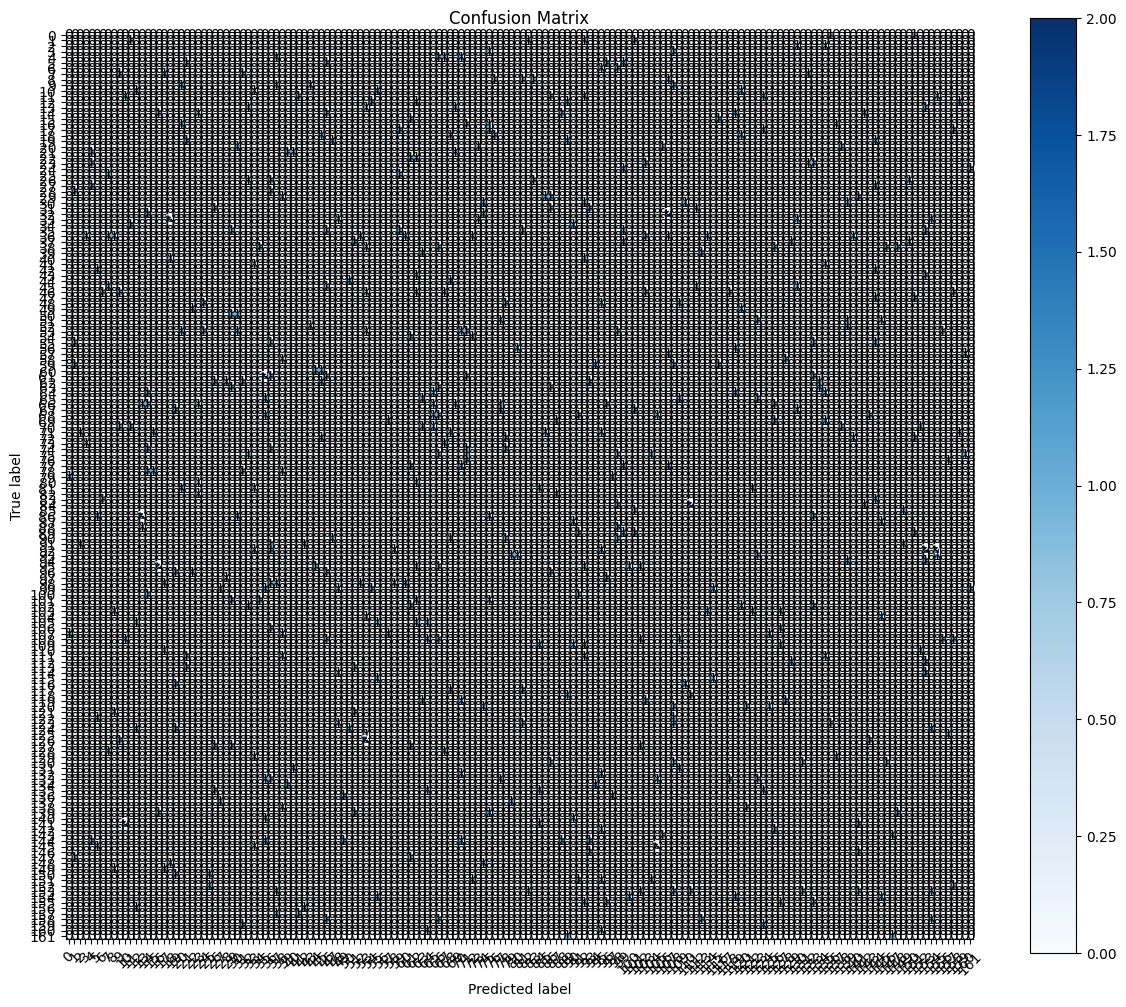

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# Replace with the actual true and predicted labels
y_true = test_generator.classes
y_pred = model_vgg16_loaded.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = list(range(confusion.shape[0]))  # Assuming class labels are integers from 0 to 84

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = confusion.max() / 2.0
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, f"{confusion[i, j]}", ha="center", va="center", color="white" if confusion[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
